## Pilot analysis of 2d spatial simulations

Maggie Steiner, April 2023 (code adapted from Chris Porras)

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import cm as cm
import argparse
import random
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.special import binom
import sys

### Functions

`simulate_WF`: Wright-Fisher simulation on 2D lattice

In [2]:
def simulate_WF(m,dims,pop_size,s,num_intervals):
    # create array of (num_intervals) matrices each with dimensions given by dims
    output = np.zeros(tuple([num_intervals]) + dims)
    # for positive value of s, interval size is 1/s
    if s > 0:
        interval = int(1 / s)
    else: # if s=0, interval=100
        interval = 100
    # number of generations to simulate
    num_gens = interval * num_intervals
    # create array to store frequencies
    f = np.zeros(dims)
    # choose random deme & initialize variant there
    # *this is changed from old version - was always initialized in the same place*
    rand_x, rand_y = random.randint(0, dims[0] - 1), random.randint(0, dims[1] - 1)
    # initialize at frequency 1/N
    f[rand_x, rand_y] = 1 / pop_size
    ## pre-allocate list of when reset happens
    reset_gens = []
    for i in range(num_gens):
        # Wright-Fisher diffusion w/Stepping Stone migration
        df = - s * f * (1 - f) + m * laplace(f, mode='wrap')
        # bounds allele frequencies in [0,1]
        p = np.clip(a=f + df, a_min=0, a_max=1)
        # binomial sampling from frequencies
        new_f = np.random.binomial(pop_size, p) / pop_size
        # Check for extinct allele
        if np.all(new_f == 0):
            ## if extinct, store previous freqs and reset
            reset_gens.append(i)
            ## Initialize new allele
            rand_x, rand_y = random.randint(0, dims[0] - 1), random.randint(0, dims[1] - 1)
            new_f[rand_x, rand_y] = 1 / pop_size
        # Assign next frequencies
        f = new_f
        # store freqs every 1/s
        if (i + 1) % interval == 0:
            output[i // interval] = f
    return output

`sample_f`: apply Gaussian filter with a range of $\sigma$ values

In [3]:
def sample_f(f):
    # values of sigma to sample - from 1 to width of grid
    sig_arr =  np.arange(f.shape[-1])+1
    # create array with copy of f for each entry in sig_arr
    f_filt = np.zeros((tuple([len(sig_arr)])+f.shape))
    # iterate over values of sigma
    for i,sig in enumerate(sig_arr):
        # for each entry in matrix
        for j in range(f.shape[0]):
            for k in range(f.shape[1]):
                # frequency stored in f_filt is gaussian filter applied to frequency in f
                # sigma defines width of kernel
                f_filt[i,j,k]=gaussian_filter(f[j,k],sigma=sig,mode="wrap")
    return f_filt

`freq_sfs`: compute SFS using binomial sampling

In [4]:
def freq_sfs(f,n):
    # create array to store entries of sfs
    sfs = np.zeros(tuple([n + 1]) + f.shape)
    # iterate over entries in sfs
    for j in range(n + 1):
        # calculate SFS entry from frequency using binomial sampling
        sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
    return sfs

`plot_sfs`: plot SFS

In [5]:
def plot_sfs(f,n,s,pop_size,m,ymin=None,ymax=None,outname="output.png",xmax=None):
    # store list of sigma values
    sig_list = np.arange(f.shape[-1]) + 1
    # sample from f with range of sigma
    f_filt = sample_f(f)
    # j is allele count, range 1 to n
    j = np.arange(1,n+1) # ignore j=0
    # average sampled f over intervals,reps, dims
    sfs = freq_sfs(f_filt,n).T
    # avg over both spatial dimensions & generations
    sfs_avg = np.mean(sfs,axis=(0,1,2))
    # make plot over j for all sfs(s,sigma)
    plt.figure(figsize=(10, 5))
    title = (r'$\xi_{s,\sigma}$' + f' n={n} s={s} '
             + r'$Ns$=' + f'{pop_size * s} '
             + r'$m$='+f'{m} '
             + r'$d_c=$' + f'{np.sqrt(m / s)}')
    plt.title(title)
    plt.xlabel(r'$j$')
    plt.ylabel(r'$\xi_{s,\sigma}$')
    norm_vals = mcolors.Normalize(vmin=sig_list.min(),vmax=sig_list.max())
    colormap = cm.plasma
    for i in range(len(sig_list)):
        plt.loglog(j, sfs_avg[sig_list[i]-1,1:], color=colormap(norm_vals(i)))
        plt.xlim(1, n)
        plt.ylim(ymin,ymax)
    sm = cm.ScalarMappable(norm=norm_vals,cmap=colormap)
    sm.set_array(sig_list)
    plt.colorbar(sm,label=r'$\sigma$')
    if xmax is not None:
        plt.xlim(1,xmax)
    plt.show()
#     plt.savefig(outname,format='png')
#     return sfs

### Test simulation

In [8]:
# set parameters
m = 1e-1
dims = (20,20)
pop_size = 1e3
s = 1e-2
n = 100
num_intervals = 100
ymin = 1e-8
ymax = 1e-1
seed = 1234

# set seed
random.seed(seed)

In [50]:
# run simulation
output = simulate_WF(m,dims,pop_size,s,num_intervals)

In [51]:
print(output.shape)

(100, 20, 20)


In [52]:
# print(output[0])
# print(output[99])

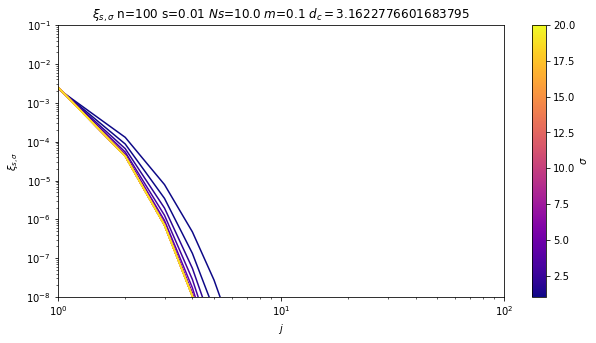

In [53]:
plot_name='sfs_n'+str(n)+'_s'+str(s)+'_m'+str(m)+"_N"+str(pop_size)+"_dim"+str(dims[0])+"x"+str(dims[1])+".png"
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=ymin,ymax=ymax)

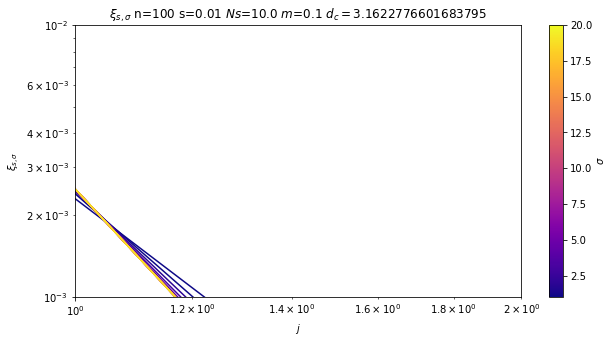

In [59]:
plot_name='sfs_n'+str(n)+'_s'+str(s)+'_m'+str(m)+"_N"+str(pop_size)+"_dim"+str(dims[0])+"x"+str(dims[1])+".png"
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=1e-3,ymax=1e-2,xmax=2)

### Changing Ns and n

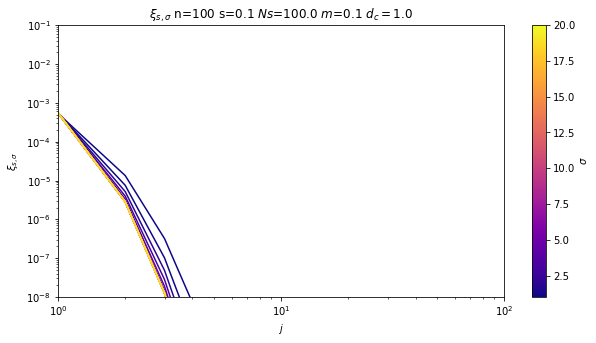

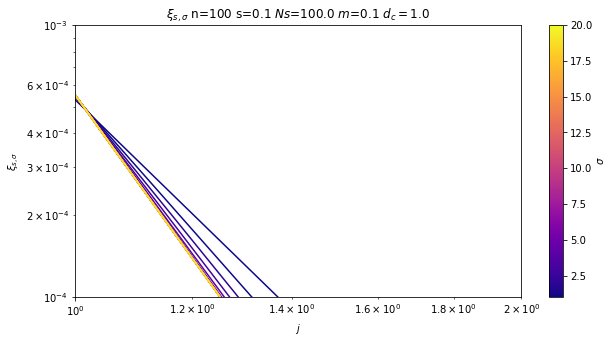

In [63]:
# set parameters
m = 1e-1
dims = (20,20)
pop_size = 1e3
s = 1e-1
n = 100
num_intervals = 100
ymin = 1e-8
ymax = 1e-1
seed = 1234

# run simulation
output = simulate_WF(m,dims,pop_size,s,num_intervals)

plot_name='sfs_n'+str(n)+'_s'+str(s)+'_m'+str(m)+"_N"+str(pop_size)+"_dim"+str(dims[0])+"x"+str(dims[1])+".png"
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=ymin,ymax=ymax)
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=1e-4,ymax=1e-3,xmax=2)

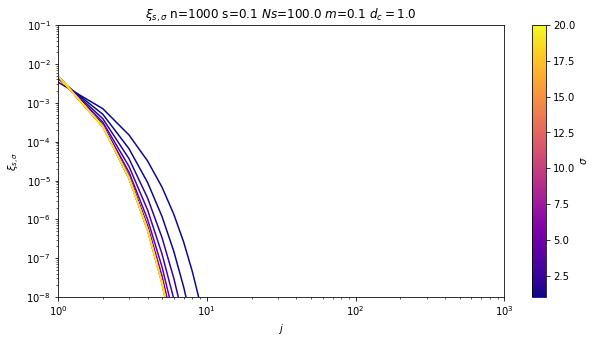

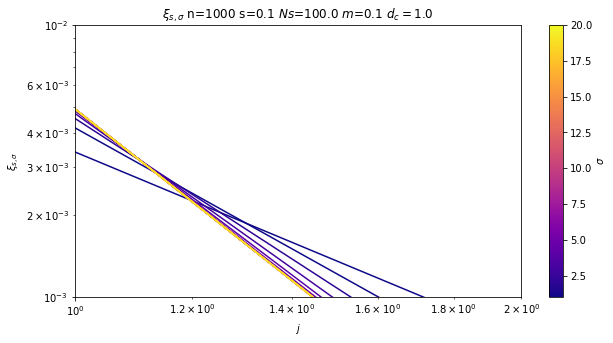

In [65]:
# set parameters
m = 1e-1
dims = (20,20)
pop_size = 1e3
s = 1e-1
n = 1000
num_intervals = 100
ymin = 1e-8
ymax = 1e-1
seed = 1234

# run simulation
output = simulate_WF(m,dims,pop_size,s,num_intervals)

plot_name='sfs_n'+str(n)+'_s'+str(s)+'_m'+str(m)+"_N"+str(pop_size)+"_dim"+str(dims[0])+"x"+str(dims[1])+".png"
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=ymin,ymax=ymax)
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=1e-3,ymax=1e-2,xmax=2)

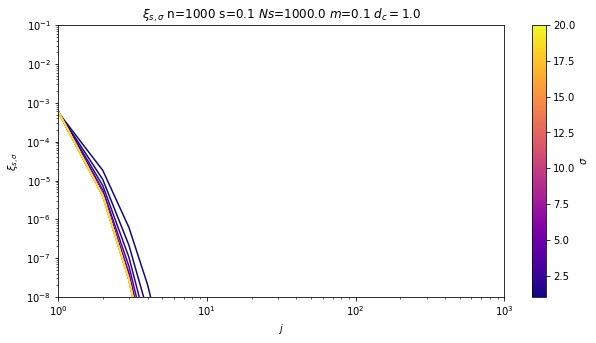

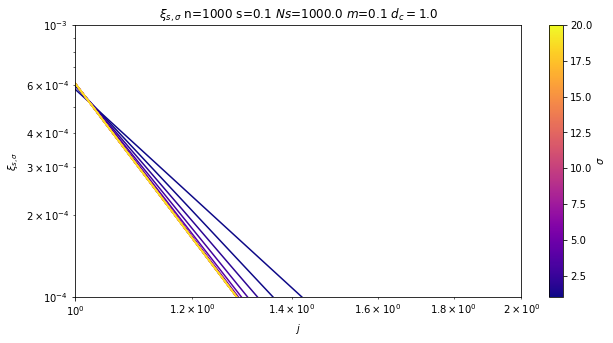

In [10]:
# set parameters
m = 1e-1
dims = (20,20)
pop_size = 1e4
s = 1e-1
n = 1000
num_intervals = 100
ymin = 1e-8
ymax = 1e-1
seed = 1234

# run simulation
output = simulate_WF(m,dims,pop_size,s,num_intervals)

plot_name='sfs_n'+str(n)+'_s'+str(s)+'_m'+str(m)+"_N"+str(pop_size)+"_dim"+str(dims[0])+"x"+str(dims[1])+".png"
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=ymin,ymax=ymax)
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=1e-4,ymax=1e-3,xmax=2)

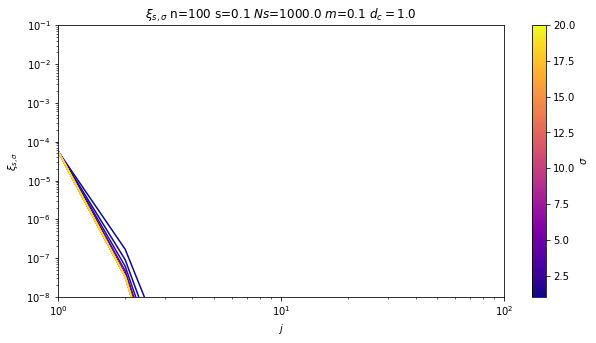

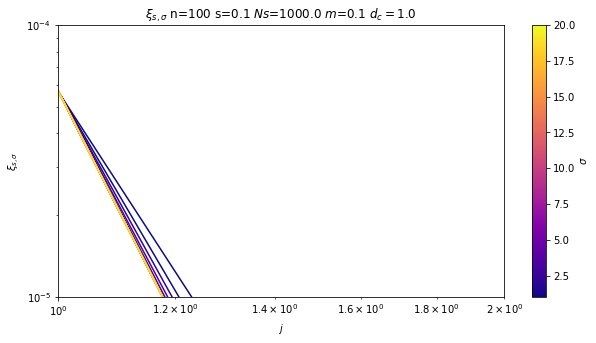

In [12]:
# set parameters
m = 1e-1
dims = (20,20)
pop_size = 1e4
s = 1e-1
n = 100
num_intervals = 100
ymin = 1e-8
ymax = 1e-1
seed = 1234

# run simulation
output = simulate_WF(m,dims,pop_size,s,num_intervals)

plot_name='sfs_n'+str(n)+'_s'+str(s)+'_m'+str(m)+"_N"+str(pop_size)+"_dim"+str(dims[0])+"x"+str(dims[1])+".png"
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=ymin,ymax=ymax)
plot_sfs(output,n,s=s,m=m,pop_size=pop_size,outname=plot_name,ymin=1e-5,ymax=1e-4,xmax=2)